In [2]:
# CBOW model in TF based on 
# https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

import zipfile
import collections
import nltk
import numpy as np
import math 

import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [16]:
# this assumes the file is in the same directory
file = "text8.zip"

# define new vocab size too reduce computation
vocabulary_size = 50000

# params for training
batch_size = 128
embedding_size = 128
context_size = 5
n_steps = 20000
avg_loss_step = 100

# params of validation set
validation_size = 16
validation_window = 100
validation_examples = np.random.choice(validation_window, validation_size, replace=False)
num_sampled = 64
k = 8

In [4]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        text = tf.compat.as_str(f.read(f.namelist()[0])).split()

    print('Text has length of {}'.format(len(text)))
    return nltk.Text(text)


def build_dataset(text, vocab_size):
    print("Started to build data set.")
    # replace words occurring less frequent than vocab size with UNK
    fdist = nltk.FreqDist(text)
    vocab = [word for word,_ in fdist.most_common(vocab_size)]
    text = [word if word in vocab else 'UNK' for word in text]
    fdist = nltk.FreqDist(text)

    # generate code for each word
    dictionary = dict()
    for word, _ in fdist.items():
        dictionary[word] = len(dictionary)
    
    # generate code <-> word mapping 
    data = list()
    for word in text:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        data.append(index)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    print("Finished building data set.")
    return data, fdist, dictionary, reverse_dictionary

In [5]:
def get_batch(text, batch_size, context_size):
    
    # container for training
    x = np.empty(shape=(batch_size, context_size*2), dtype=np.int32)
    y = np.empty(shape=(batch_size, 1), dtype=np.int32)
    
    # left and right context plus target itself
    span_size = 2 * context_size + 1 
    buffer = collections.deque(maxlen=span_size)
    
    # given: [context left] target [context right]
    # generate: input: [context left, context right] ; label: target
    
    idx = 0
    
    # fill buffer with [context left] target [context right]
    for i in range(span_size):
        buffer.append(text[idx])
        idx = (idx + 1) % len(text)
    
    # create batch 
    for i in range(batch_size):
        # get left and right context of target
        x[i] = [token for j, token in enumerate(buffer) if j != context_size]
        # get target 
        y[i] = buffer[context_size]
        # add new elem at end (first gets removed)
        buffer.append(text[idx])
        # shift idx to cover next element 
        idx = (idx + 1) % len(text)
        
    return x, y

In [6]:
text = read_data(file)
text, fdist, dictionary, reverse_dictionary = build_dataset(text, vocabulary_size)

print('10 most common tokens: {}'.format(fdist.most_common(10)))

Text has length of 17005207
Started to build data set.
Finished building data set.
10 most common tokens: [('the', 1061396), ('of', 593677), ('UNK', 418382), ('and', 416629), ('one', 411764), ('in', 372201)]


In [7]:
graph = tf.Graph()

with graph.as_default():
    
    # data container for input
    x = tf.placeholder(tf.int32, shape=[batch_size, context_size*2])
    y = tf.placeholder(tf.int32, shape=[batch_size, 1])
    validation_dataset = tf.constant(validation_examples, dtype=tf.int32)

    # embeddings for input
    with tf.name_scope("embeddings"):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, x)
        embed_context = tf.reduce_mean(embed, 1)

    # NCE input
    with tf.name_scope('nce_weights'):
        W_nce = tf.Variable(
            tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('nce_biases'):
        b_nce = tf.Variable(tf.zeros([vocabulary_size]))
    
    # optimizer for NCE loss
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                W_nce, b_nce, y, embed_context, num_sampled, vocabulary_size))
    
        tf.summary.scalar('loss', loss)
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # cosine similarity
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    norm_embeddings = embeddings // norm
    validation_embeddings = tf.nn.embedding_lookup(norm_embeddings, validation_dataset)
    cosine_sim = tf.matmul(validation_embeddings, norm_embeddings, transpose_b=True)
    
    init = tf.global_variables_initializer() 

In [17]:
with tf.Session(graph=graph) as sess:
    
    init.run()
    loss_progress = np.zeros(shape=(n_steps,))
    avg_loss_progress = np.zeros(shape=(n_steps//avg_loss_step,))
    
    for step in range(n_steps):
                
        batch_x, batch_y = get_batch(text, batch_size, context_size)
        _, val_loss = sess.run([optimizer, loss], feed_dict={x: batch_x, y: batch_y})
        
        avg_step = step//avg_loss_step
        loss_progress[step] = val_loss
        avg_loss_progress[avg_step] += val_loss
        
        # print progress
        if step % avg_loss_step == 0:
            print("Average loss at step {}: {}".format(step, avg_loss_progress[avg_step] / avg_loss_step))
            
    # evaluate at the end on validation set
    sim = cosine_sim.eval()
    
    for i in range(validation_size):

        validation_word = reverse_dictionary[validation_examples[i]]

        nearest = (-sim[i, :]).argsort()[1:k + 1]
        base_string = "Best words for {}:".format(validation_word)

        for j in range(k):
            word = reverse_dictionary[nearest[j]]
            base_string = "{} {},".format(base_string, word) if not j==(k-1) else "{} {}".format(base_string, word)

        print(base_string)
                
    final_embeddings = norm_embeddings.eval()

Average loss at step 0: 3.2637298583984373
Average loss at step 100: 2.84473876953125
Average loss at step 200: 2.634684753417969
Average loss at step 300: 2.8314547729492188
Average loss at step 400: 2.756322021484375
Average loss at step 500: 2.8575949096679687
Average loss at step 600: 2.9254751586914063
Average loss at step 700: 2.813060302734375
Average loss at step 800: 2.4883108520507813
Average loss at step 900: 2.651341552734375
Average loss at step 1000: 2.965645751953125
Average loss at step 1100: 2.7961279296875
Average loss at step 1200: 2.6249591064453126
Average loss at step 1300: 2.774705505371094
Average loss at step 1400: 2.8274365234375
Average loss at step 1500: 2.306522216796875
Average loss at step 1600: 2.4710659790039062
Average loss at step 1700: 2.32018310546875
Average loss at step 1800: 2.2823385620117187
Average loss at step 1900: 2.5590255737304686
Average loss at step 2000: 2.618724060058594
Average loss at step 2100: 2.0516180419921874
Average loss at st

Average loss at step 17900: 0.8787452697753906
Average loss at step 18000: 0.7855208587646484
Average loss at step 18100: 0.5209098052978516
Average loss at step 18200: 0.5520224761962891
Average loss at step 18300: 0.45944526672363284
Average loss at step 18400: 0.45653644561767576
Average loss at step 18500: 0.6169859313964844
Average loss at step 18600: 0.4674151611328125
Average loss at step 18700: 0.4633734130859375
Average loss at step 18800: 0.5642897033691406
Average loss at step 18900: 0.7066521453857422
Average loss at step 19000: 0.4359320831298828
Average loss at step 19100: 0.28792640686035154
Average loss at step 19200: 0.22511226654052735
Average loss at step 19300: 0.9441653442382812
Average loss at step 19400: 0.6511187744140625
Average loss at step 19500: 0.5123625564575195
Average loss at step 19600: 0.47505382537841795
Average loss at step 19700: 0.6630014038085937
Average loss at step 19800: 0.4930702209472656
Average loss at step 19900: 0.42279556274414065
Best wo

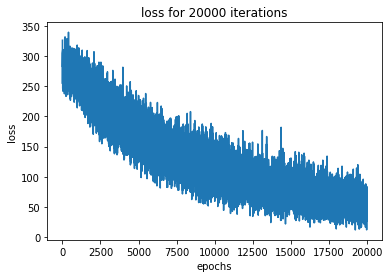

In [20]:
plt.figure(1)
plt.plot(range(n_steps), loss_progress)
plt.title("loss for {} iterations".format(n_steps))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

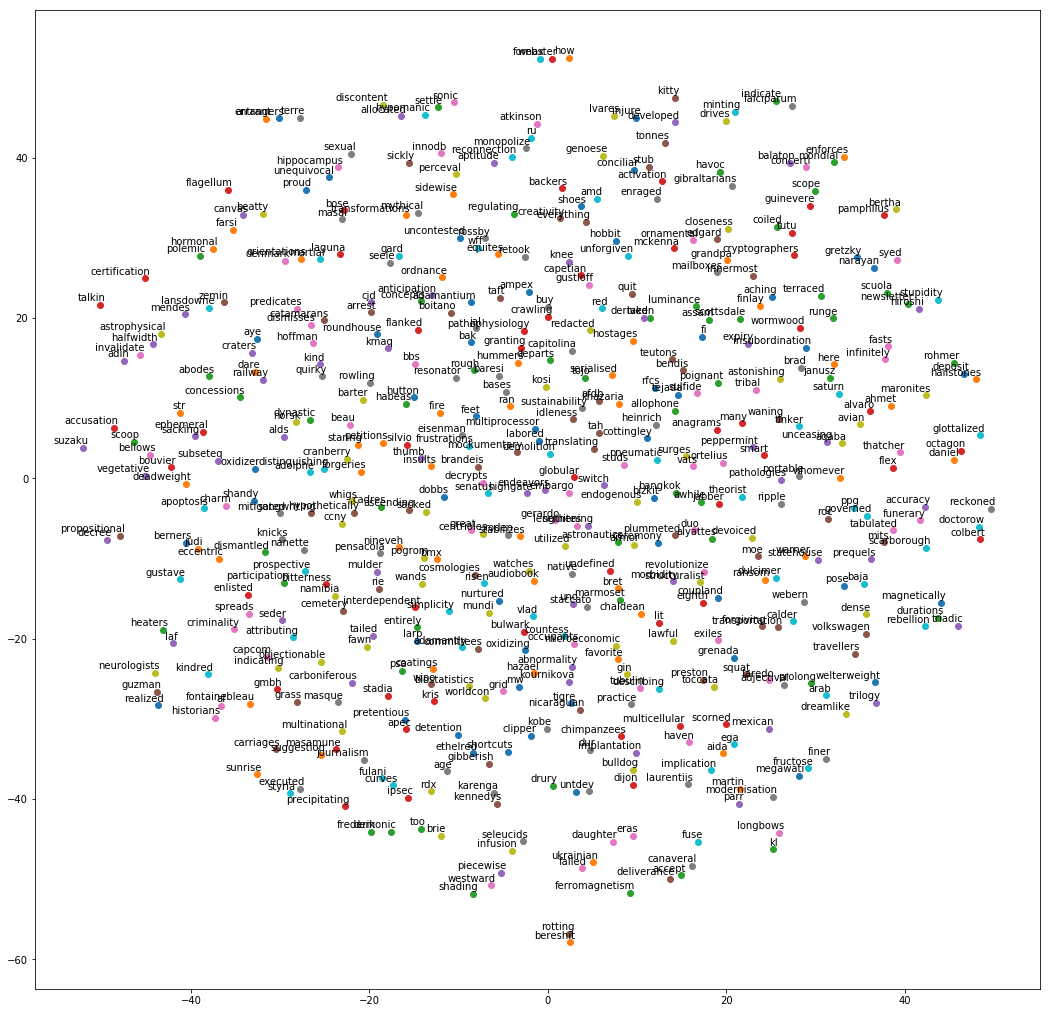

In [19]:
# shamelessly borrowed from https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 
def plot_with_labels(low_dim_embs, labels):
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.show()


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)